# Exploration of Flight Data
## by Brandon Nohara

## Preliminary Wrangling

This document explores a dataset containing flight delay information for approximately 18 million flights from 1988, 1998, and 2007.

In [300]:
# Import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import time

%matplotlib inline

In [301]:
# Load in the dataset into a pandas dataframe
df_1988 = pd.read_csv('data/1988.csv')
df_1998 = pd.read_csv('data/1998.csv')
df_2007 = pd.read_csv('data/2007.csv')

In [302]:
# High-level overview of data shape and composition
print(df_1988.info())
print(df_1998.info())
print(df_2007.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202096 entries, 0 to 5202095
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            float64
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     int64  
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           float64
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   float64
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

In [303]:
# Make sure there is a full year of data for 2007. The csv file for 2008 only had data through April.
df_2007['Month'].value_counts().sort_index()

1     621559
2     565604
3     639209
4     614648
5     631609
6     629280
7     648560
8     653279
9     600187
10    629992
11    605149
12    614139
Name: Month, dtype: int64

In [304]:
# Concatenate data for different years. Check high level data shape and composition again.
frames = [df_1988, df_1998, df_2007]
df_flights = pd.concat(frames)
print(df_flights.shape)
print(df_flights.head())
print(df_flights.describe())

(18040032, 29)
   Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  1988      1           9          6   1348.0        1331   1458.0   
1  1988      1          10          7   1334.0        1331   1443.0   
2  1988      1          11          1   1446.0        1331   1553.0   
3  1988      1          12          2   1334.0        1331   1438.0   
4  1988      1          13          3   1341.0        1331   1503.0   

   CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
0        1435            PI        942  ...    NaN      NaN          0   
1        1435            PI        942  ...    NaN      NaN          0   
2        1435            PI        942  ...    NaN      NaN          0   
3        1435            PI        942  ...    NaN      NaN          0   
4        1435            PI        942  ...    NaN      NaN          0   

   CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0               NaN         0           NaN 

In [305]:
df_flights[['CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay']].describe()

,CRSElapsedTime,AirTime,ArrDelay,DepDelay
count,1.803665e+07,1.250234e+07,1.763984e+07,1.768461e+07
mean,1.198104e+02,1.028660e+02,8.358667e+00,9.328522e+00
std,6.832489e+01,6.716235e+01,3.300439e+01,3.105522e+01
min,-1.240000e+03,0.000000e+00,-1.233000e+03,-1.000000e+03
25%,7.000000e+01,5.400000e+01,-7.000000e+00,-2.000000e+00
50%,1.010000e+02,8.400000e+01,0.000000e+00,0.000000e+00
75%,1.500000e+02,1.310000e+02,1.200000e+01,8.000000e+00
max,1.560000e+03,1.257000e+03,2.598000e+03,2.601000e+03


### Rows To Remove
1. ActualElapsedTime < 0
2. CRSElapsedTime < 0

These look like invalid data, as the length of the flight should not be negative.

In [306]:
df_flights = df_flights[df_flights.ActualElapsedTime >= 0]

In [307]:
df_flights = df_flights[df_flights.CRSElapsedTime >= 0]

In [308]:
df_flights.shape

(17639795, 29)

### What is the structure of your dataset?

The dataset contains info on 18 million flights from 1988, 1998, and 2007. Initially I wanted to use data from 2008, but only some of the data from this year was available. Time features in the dataset include the date, as well as the scheduled and actual departure and arrival times. Numerical columns indicate the length and distance of the flight, and the length of delays. Categorical variables indicate the type of delay, if any, and whether the flight was cancelled or diverted. Other features are the airline carrier, origin, and destination.

### What is/are the main feature(s) of interest in your dataset?

My primary interest is quantifying the length of delays for different cities.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

Origin city, destination city, and length of delay are the main features I will focus on. It may be interesting to see if the results change over the years as well.

## Univariate Exploration

In [309]:
# To start, I'll look at a distribution of arrival delay times.
# Practically speaking, it's probably not too much inconvenience if a flight is delayed by less than 10 minutes. 
# I'll set that as the lower bound to look at.

df_delays = df_flights[df_flights.ArrDelay >= 10]
print(df_delays.shape)
df_delays['ArrDelay'].describe()

(5074998, 29)


count    5.074998e+06
mean     4.058071e+01
std      4.630165e+01
min      1.000000e+01
25%      1.500000e+01
50%      2.400000e+01
75%      4.700000e+01
max      2.598000e+03
Name: ArrDelay, dtype: float64

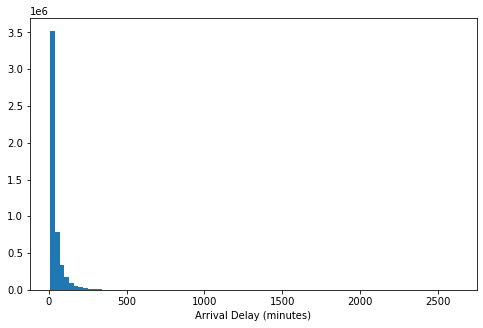

In [310]:
binsize = 30
bins = np.arange(10, df_delays['ArrDelay'].max() + binsize, binsize)

plt.figure(figsize=[8,5])
plt.hist(data = df_delays, x = 'ArrDelay', bins = bins)
plt.xlabel('Arrival Delay (minutes)')
plt.show()

Arrival delay has a long tail distribution. Let's plot it on a log scale instead.

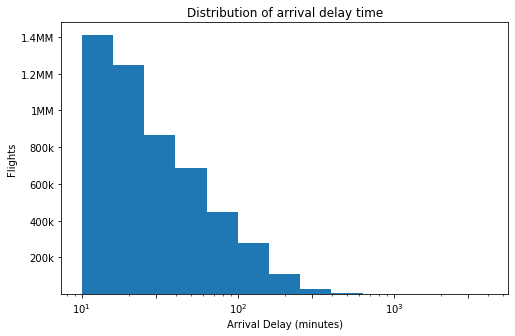

In [311]:
log_binsize = 0.2
bins = 10 ** np.arange(1, np.log10(df_delays['ArrDelay'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8,5])
plt.hist(data = df_delays, x = 'ArrDelay', bins = bins)
plt.title('Distribution of arrival delay time')
plt.xscale('log')
plt.xticks([10, 30, 100, 300, 1000, 3000])
plt.xlabel('Arrival Delay (minutes)')
plt.yticks(ticks=[200000, 400000, 600000, 800000, 1000000, 1200000, 1400000], labels=['200k', '400k', '600k', '800k', '1MM', '1.2MM', '1.4MM'])
plt.ylabel('Flights')
plt.show()

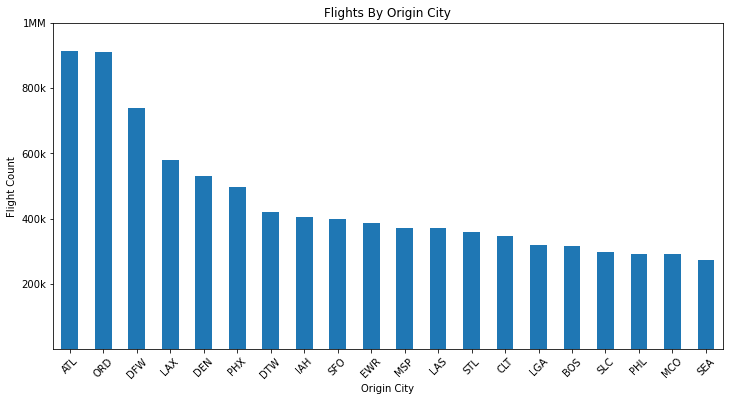

In [312]:
# Next, I'll look at a distribution of flights by origin and destination cities.
# To help keep things easy to see, I'll limit this to the cities with the most flights.

plt.figure(figsize=[12,6])
df_flights['Origin'].value_counts()[:20].plot(kind='bar')
plt.yticks(ticks=[200000, 400000, 600000, 800000, 1000000], labels=['200k', '400k', '600k', '800k', '1MM'])
plt.xticks(rotation=45)
plt.ylabel('Flight Count')
plt.xlabel('Origin City')
plt.title('Flights By Origin City');

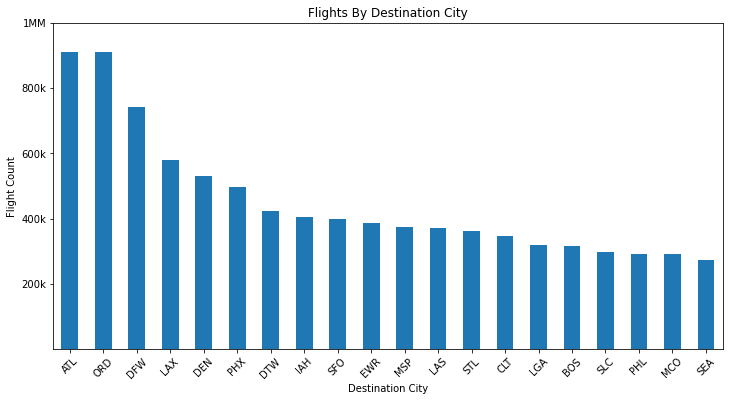

In [313]:
plt.figure(figsize=[12,6])
df_flights['Dest'].value_counts()[:20].plot(kind='bar')
plt.yticks(ticks=[200000, 400000, 600000, 800000, 1000000], labels=['200k', '400k', '600k', '800k', '1MM'])
plt.xticks(rotation=45)
plt.ylabel('Flight Count')
plt.xlabel('Destination City')
plt.title('Flights By Destination City');

The same cities are present in the two charts above. It's probably more practical to look at delays for destination cities, as people don't have as much choice about the origin city when planning a trip. Going forward, I'll focus on destination city rather than origin city.

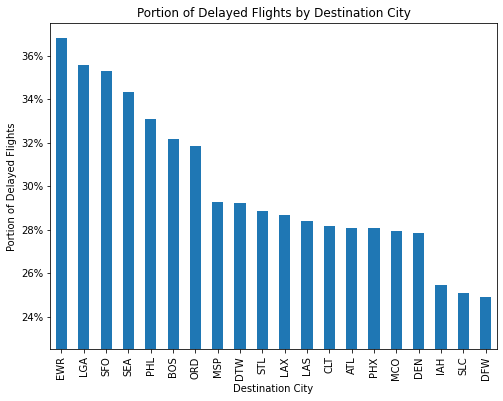

In [314]:
# For the destination cities with the most flights, let's look at at the portion of flights that had a delay.

all_dest = df_flights['Dest'].value_counts()[:20]
delay_dest = df_delays['Dest'].value_counts()

delay_portion_dest = delay_dest.divide(all_dest, fill_value=0)
delay_portion_dest.sort_values(ascending=False, inplace=True)
delay_portion_dest.replace(np.inf, np.nan, inplace=True)
delay_portion_dest.dropna(inplace=True)

plt.figure(figsize=[8,6])
delay_portion_dest.plot(kind='bar')
plt.ylim(0.225,0.375)
plt.yticks(ticks=[0.24,0.26,0.28,0.30,0.32,0.34,0.36], labels=['24%','26%','28%','30%','32%','34%','36%'])
plt.ylabel('Portion of Delayed Flights')
plt.xlabel('Destination City')
plt.title('Portion of Delayed Flights by Destination City');

We've got some variation in the portion of flights with delays across these top cities. It will be interesting to break down these delays by the other features in the data set - delay time, delay type, and year.

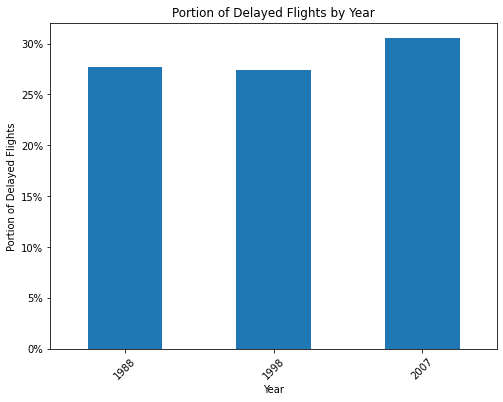

In [315]:
# Finally, we'll see if the portion of delayed flights changed over the years

flights = df_flights['Year'].value_counts()
delays = df_delays['Year'].value_counts().sort_index()
delay_portion = delays.divide(flights)

plt.figure(figsize=[8,6])
delay_portion.plot(kind='bar')
plt.yticks(ticks=[0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30], labels=['0%', '5%', '10%', '15%', '20%', '25%', '30%'])
plt.ylabel('Portion of Delayed Flights')
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.title('Portion of Delayed Flights by Year');

The portion of delayed flights was around 27% in 1988 and 1998, but increased to around 30% in 2007.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The distribution of arrival delay times had a long tail, so I used a log transform for the histogram. The transform showed a strong right skew, with most arrival delays at under 60 minutes.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

I looked at the portion of flights with delays for the cities with the most flights. This gives us a sense of how likely it is that there will be a delay, which will be more useful than the raw count of delays for these popular destination cities.

## Bivariate Exploration
In the bivariate exploration, we'll look at three relationships in the data:
1. Delay time by destination city
2. Delay time by year
3. Portion of flights with delays by destination city and year

### 1. Delay time by destination city

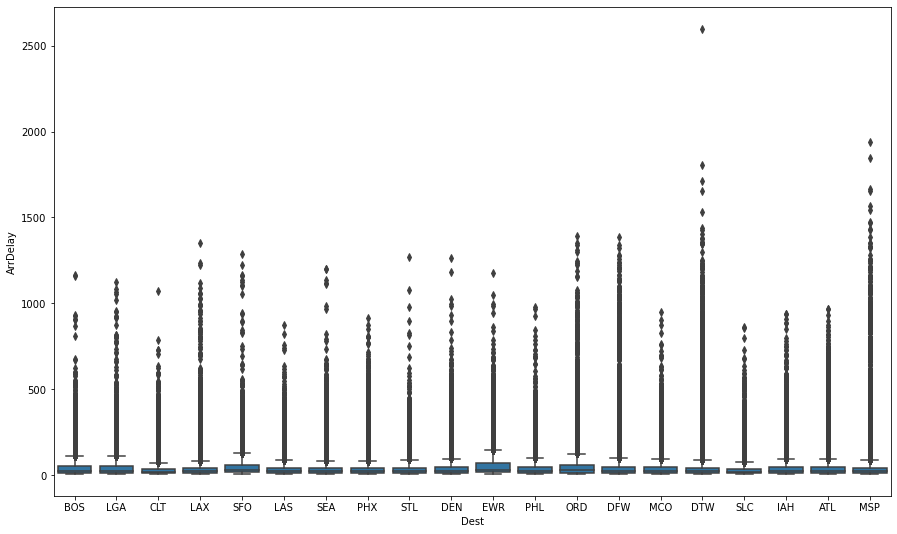

In [316]:
# Filter on flights with delays from one of the top 20 destination cities
cities = pd.Series(df_flights['Dest'].value_counts()[:20].index)
boolean_series = df_delays.Dest.isin(cities)
df_delays_top_dest = df_delays[boolean_series]

plt.figure(figsize=[15,9])
base_color = sb.color_palette()[0]
sb.boxplot(data=df_delays_top_dest, x='Dest', y='ArrDelay', color=base_color);

Let's remove the outliers with extremely high delay times. That should make it easier to see the trend.

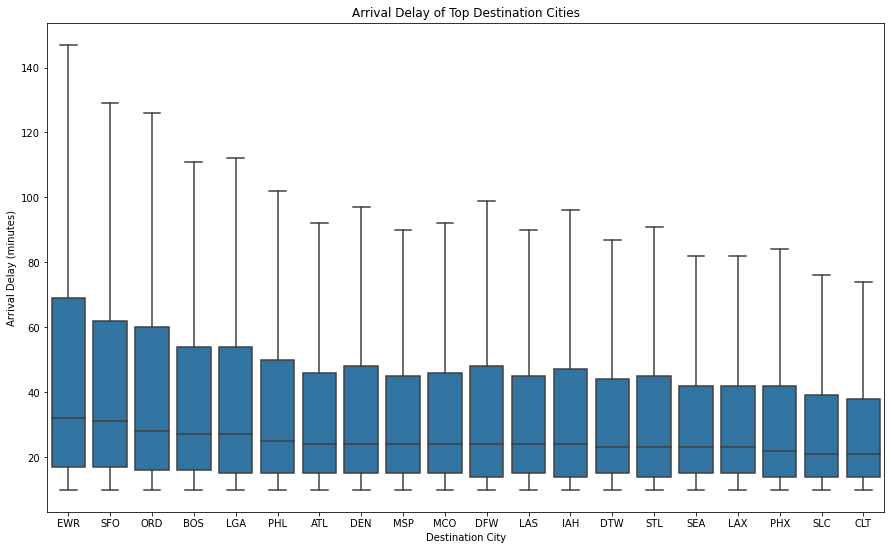

In [317]:
plt.figure(figsize=[15,9])

# Let's order the boxplot elements by decreasing median of 'ArrDelay'
s_dest_arrdelay = df_delays_top_dest.groupby(by=['Dest'])['ArrDelay'].median()
s_dest_arrdelay.sort_values(ascending=False, inplace=True)
list_dest_arrdelay = s_dest_arrdelay.index.tolist()

sb.boxplot(data=df_delays_top_dest, x='Dest', y='ArrDelay', showfliers=False, order=list_dest_arrdelay, color=base_color)
plt.ylabel('Arrival Delay (minutes)')
plt.xlabel('Destination City')
plt.title('Arrival Delay of Top Destination Cities');

The median arrival delay time is fairly similar across our top cities - between 20-30 minutes. Cities with higher median arrival delay time generally had a larger spread of values though.

### 2. Delay time by year

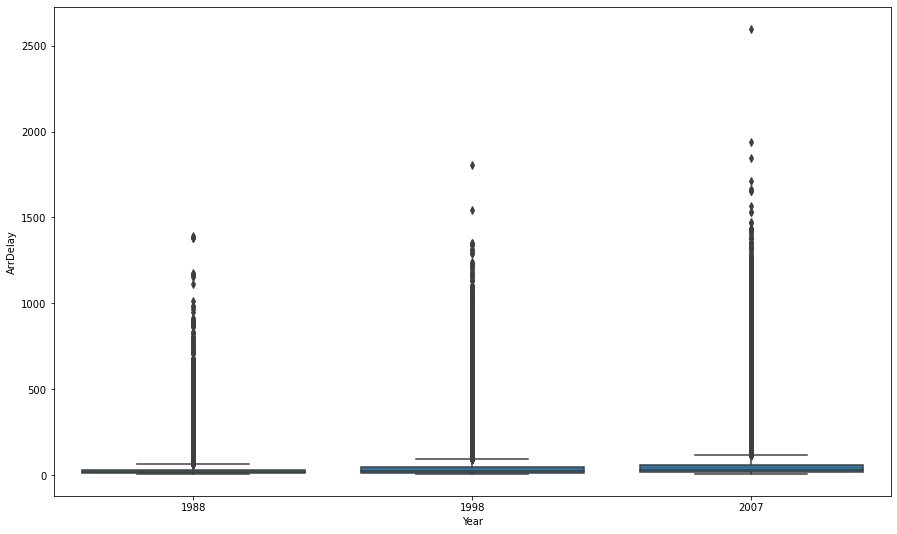

In [318]:
plt.figure(figsize=[15,9])

sb.boxplot(data=df_delays, x='Year', y ='ArrDelay', order=[1988, 1998, 2007], color=base_color);

As with the boxplot for destination city, let's remove the outliers with extremely high delay times.

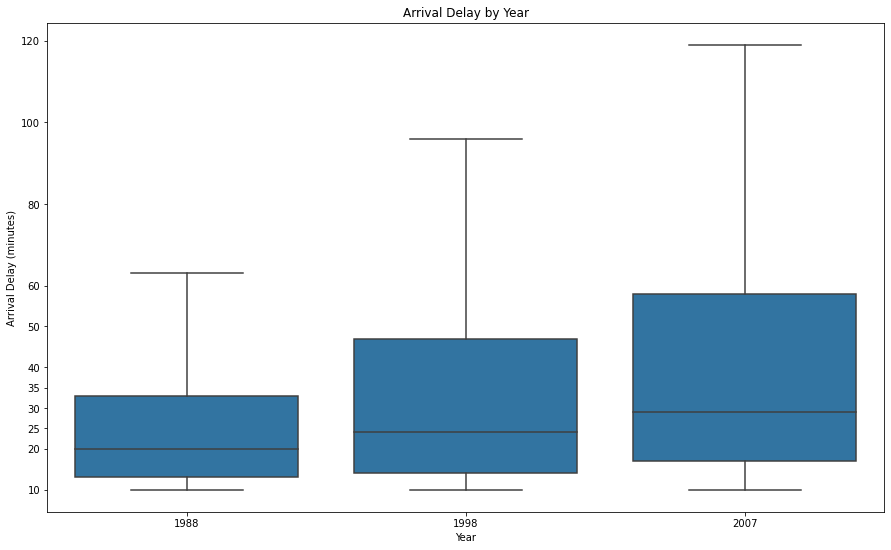

In [319]:
plt.figure(figsize=[15,9])

sb.boxplot(data=df_delays, x='Year', y='ArrDelay', showfliers=False, order=[1988, 1998, 2007], color=base_color)
plt.yticks([10,20,25,30,35,40,50,60,80,100,120])
plt.ylabel('Arrival Delay (minutes)')
plt.title('Arrival Delay by Year');

Median arrival delay time increased over the years, from around 20 minutes in 1988 to 30 minutes in 2007. From 1988 to 2007, the max value of arrival delay time nearly doubled, from around 60 minutes to 120 minutes.

### 3. Portion of flights with delays by destination city and year

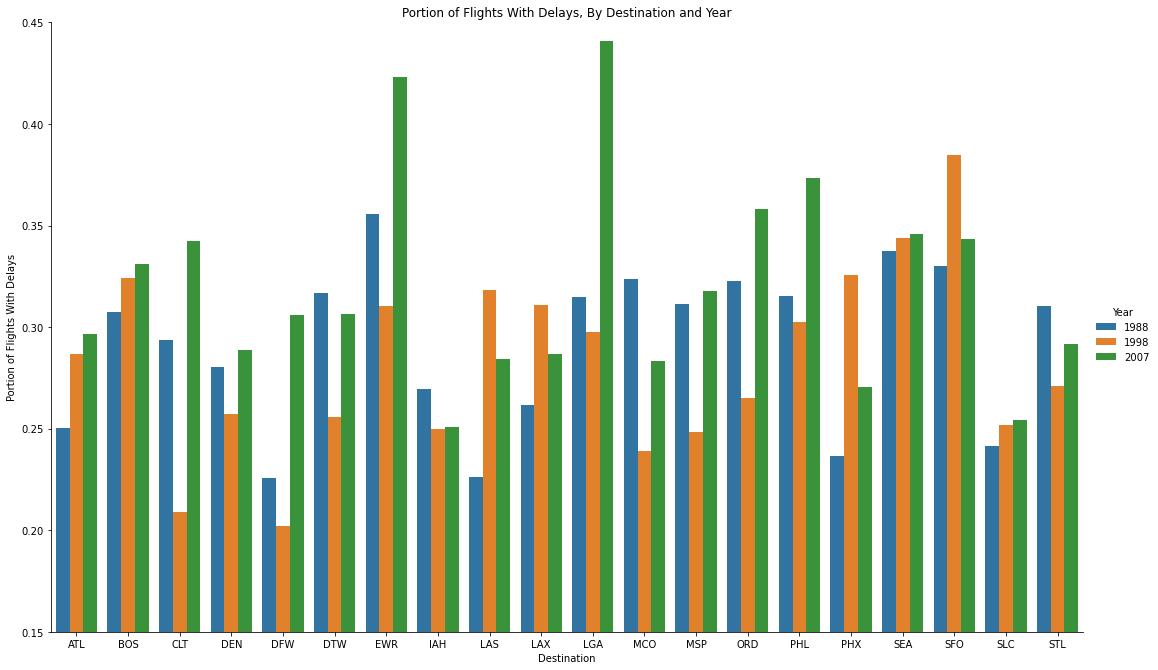

In [323]:
# Filter on flights with delays from one of the top 20 destination cities
# Use the 'cities' variable, which is a series containing the top 20 destination city names

flights_boolean_series = df_flights.Dest.isin(cities)
df_flights_top_dest = df_flights[flights_boolean_series]

s_top_dest = df_flights_top_dest.groupby(by=['Dest', 'Year'])['FlightNum'].count()
s_top_dest_delay = df_delays_top_dest.groupby(by=['Dest', 'Year'])['FlightNum'].count()
s_top_dest_delay_portion = s_top_dest_delay.divide(s_top_dest)
df_top_dest_delay_portion = s_top_dest_delay_portion.to_frame().reset_index()
df_top_dest_delay_portion.rename(columns={'FlightNum':'delay_portion'}, inplace=True)

sb.catplot(data=df_top_dest_delay_portion, kind='bar', x='Dest', y='delay_portion', hue='Year', height=9, aspect=15/9)
plt.title('Portion of Flights With Delays, By Destination and Year')
plt.ylabel('Portion of Flights With Delays')
plt.ylim(0.15, 0.45)
plt.xlabel('Destination');

For 16 of the top 20 cities, the portion of flights with delays increased from 1988 to 2007.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

For the top 20 destination cities with the most flights, the median arrival delay time was fairly similar - between 20-30 minutes. Cities with higher median arrival delay time generally had a larger spread of values though. The top 5 cities by median arrival delay time (EWR, SFO, ORD, BOS, LGA) had maximum delay times  between 110 and 150 minutes. The remaining cities generally showed a maximum delay time between 80 and 100 minutes.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Median arrival delay time increased over the 3 years in the data set, from around 20 minutes in 1988 to 30 minutes in 2007. The maximum delay times also doubled from 60 minutes in 1988 to 120 minutes in 2007.

The portion of flights with delays was higher in 2007 compared to 1988 for 16 of the top 20 cities.

## Multivariate Exploration

In this section, we'll look at the interaction between destination city, year, and arrival delay time in the same visualization. I'll start with a heat map to get a sense of the parts of our data with the longest delays.

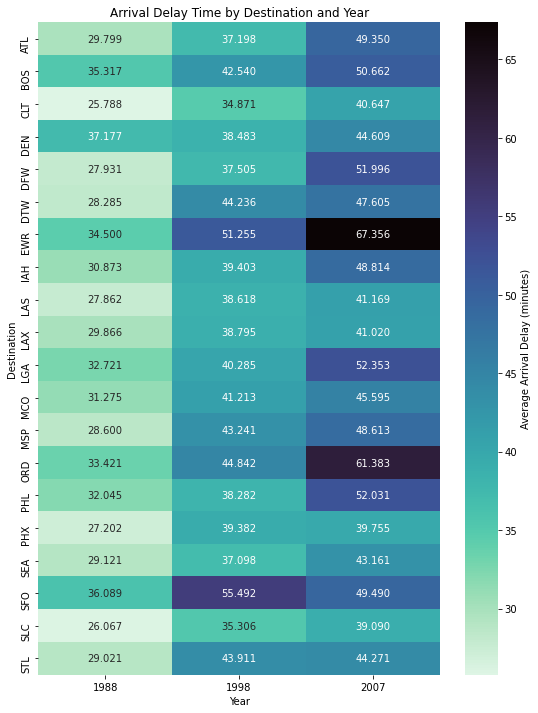

In [321]:
cat_means = df_delays_top_dest.groupby(by=['Dest', 'Year']).mean()['ArrDelay']
cat_means = cat_means.reset_index(name='ArrDelay_avg')
cat_means_pivot = cat_means.pivot(index='Dest', columns='Year', values='ArrDelay_avg')

plt.figure(figsize=[9,12])
sb.heatmap(cat_means_pivot, cmap='mako_r', annot=True, fmt='0.3f', cbar_kws={'label':'Average Arrival Delay (minutes)'})
plt.title('Arrival Delay Time by Destination and Year')
plt.ylabel('Destination');

In most of our top cities, the length of delay increased over the years. The exception was SFO, which had shorter delays in 2007 compared to 1998.

As an alternative view of this data, I'll also try a clustered bar chart. Let's see which visualization paints a clearer picture.

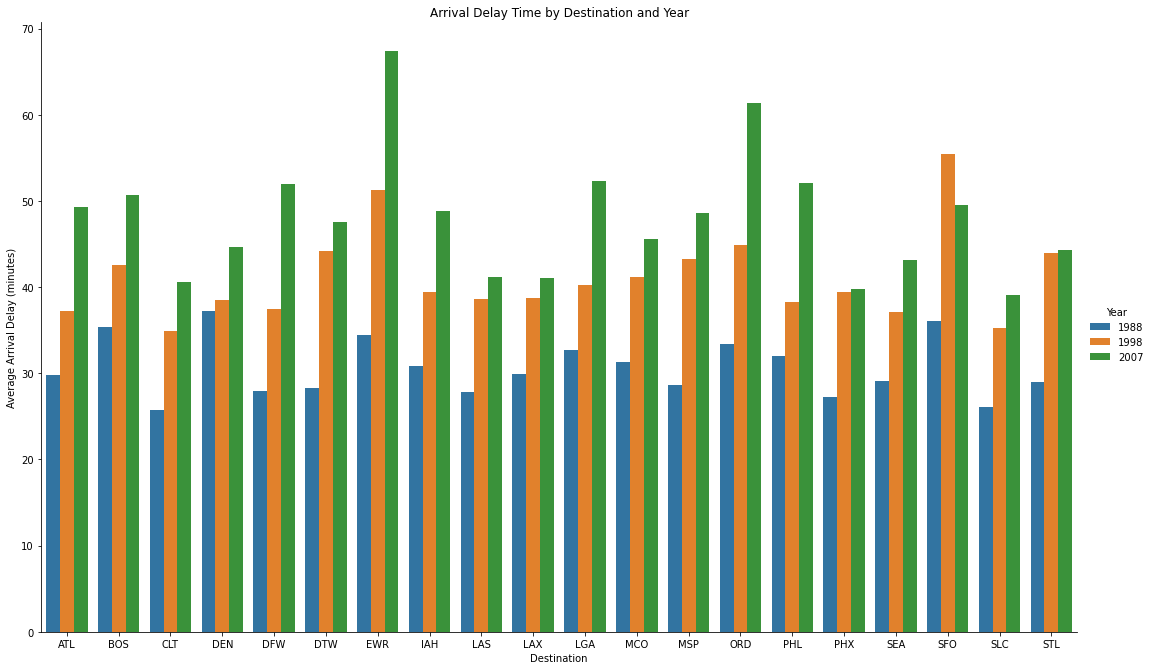

In [322]:
sb.catplot(data=cat_means, kind='bar', x='Dest', y='ArrDelay_avg', hue='Year', height=9, aspect=15/9)
plt.title('Arrival Delay Time by Destination and Year')
plt.ylabel('Average Arrival Delay (minutes)')
plt.xlabel('Destination');

The heatmap makes it easier to see the general trend of increasing delay time over the years. Meanwhile the clustered bar chart makes it easier to see the magnitude of the difference in delay time across years for each city.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

The heat map and clustered bar chart provided a clear picture of the interaction between the main features of interest: arrival delay time by destination city and year. In general, arrival delay time increased over the years for the top destination cities.

### Were there any interesting or surprising interactions between features?

What I found most interesting for the top cities was that the portion of flights with delays also generally increased over time (as shown in the clustered bar chart in the bivariate analysis).

Another interesting finding was that delay time in SFO decreased from 1998 to 2007. For all other top cities, delay time increased across these two years.